# INTRODUCTION TO MACHINE LEARNING PROJECT

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import time
from tqdm import tqdm

np.random.seed(42)

# NOTES
# TODO confirm the experimental results with theoretical results
# TODO weighted knn, weighting the closest points 
# TODO calculate variance and std to know the right number of folds
# TODO for the best k, redo cross val to tune the best distance metric
# TODO mixing/averaging distances metrics and compare the scores
# TODO modify assert into raise ValueError for user input verif
# TODO rajouter std dans les comparaisons
# TODO see if condition over k for CNN and comment in knn function
# TODO calculate the bound of R(h)<=R^(h)+Variance, but need to find the complexity measure of knn
# TODO tune K as to maximize the F-measure, see part on imbalanced dataset in lecture on KNN
# TODO plot the bias/variance tradeoff by showing that small value of k gives a low bias but high variance and inversely symmetrical
# TODO tuning the best distance metric for each feature, take each feature separately, cross val the distance metric and then get a matrix of distance metrics
# TODO use LDA and compare it to PCA
# TODO do TSNE and UMAP
# TODO do a kernel pca 
# TODO extend speeding calculation to multiple k


## Loading Data

In [39]:
def load_data(dataset_file):
    return np.loadtxt(dataset_file, delimiter=',')

data = load_data('./waveform.data')

# Splitting the features and the labels into two different arrays
features = np.array(data[:,:data.shape[1]-1])

# Normalization of the features such that each feature has a mean = 0 and std = 1
def normalization(feat_to_norm) :
    new = np.empty(shape=feat_to_norm.shape)
    for i in range(feat_to_norm.shape[1]) :
        mean = np.mean(feat_to_norm[:,i])
        std = np.std(feat_to_norm[:,i])
        new[:,i] = (feat_to_norm[:,i] - mean) / std
    return new

features = normalization(feat_to_norm=features)

labels = np.array(data[:,data.shape[1]-1:])


###  Creating the dataset in python

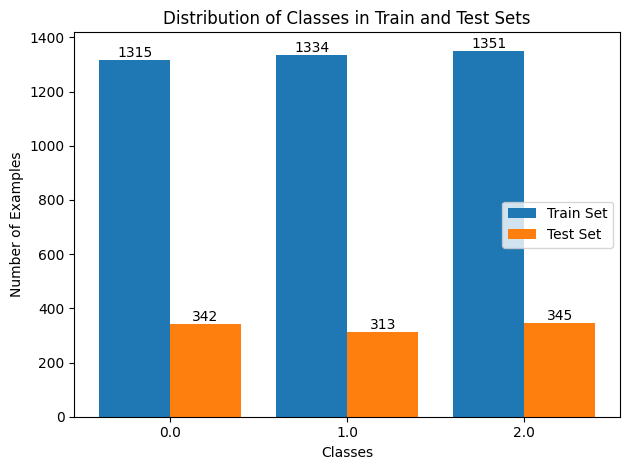

In [41]:
def train_test_split(features, labels, train_ratio):
    assert features.shape[0] == labels.shape[0], "Error : dimensions of features and labels should be the same"

    # Randomly shuffling the dataset's indices to pick randomly the training and test examples
    shuffled_indices = np.arange(features.shape[0])
    np.random.shuffle(shuffled_indices)
    train_size = int(len(shuffled_indices) * train_ratio)
    train_indices = shuffled_indices[:train_size]
    test_indices = shuffled_indices[train_size:]

    x_set = features[train_indices]
    x_test = features[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]

    assert x_set.shape[0] == y_train.shape[0], "Error : creation of training set went wrong."
    assert x_test.shape[0] == y_test.shape[0], "Error : creation of testing set went wrong."

    return x_set, x_test, y_train, y_test

#Creation of the training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(features, labels, 0.8)

#Plotting the distribution of the training and test set
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)
fig, ax = plt.subplots()
bar_width = 0.4
train_positions = np.arange(len(train_classes))
test_positions = train_positions + bar_width
bar1 = ax.bar(train_positions, train_counts, bar_width, label='Train Set')
bar2 = ax.bar(test_positions, test_counts, bar_width, label='Test Set')
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Examples')
ax.set_title('Distribution of Classes in Train and Test Sets')
ax.set_xticks(train_positions + bar_width / 2)
ax.set_xticklabels(train_classes)
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')
ax.legend()
plt.tight_layout()
plt.show()


### Various functions

In [5]:
def euclidian_distance(x1,x2):
    return float(np.sqrt(np.sum((np.array(x1) - np.array(x2))**2)))

# Returns an array with the euclidian distances from x to every x' in x_array
def euclidian_dist_array(x, x_array):
    return np.linalg.norm(x_array - x, axis=1)

# Returns a matrix with the distance for each point of matrixA with respect to matrixB
def distance_matrix(matrixA, matrixB):
    #return scipy.spatial.distance_matrix(matrixA, matrixB, p=2)
    res = np.zeros((matrixA.shape[0], matrixB.shape[0]))
    for i in range(matrixA.shape[0]):
        distance = euclidian_dist_array(matrixA[i], matrixB)
        res[i] = distance
    return res

def accuracy(nb_true, nb_total):
    return (nb_true * 100) / nb_total


#### PCA functions

## KNN Algorithm

In [ ]:
# Compute and returns the majority class from the features amongst the k nearest neighbors of a new input
# OR the distances needs to be precomputed and passed in distance_mat
# labels is composed of the corresponding labels for each value of the distance_mat

def knn(labels, k, distance_tab=None, new_input=None, features_set=None):
    # Getting the precomputed distances from the distance_tab if it is passed in the arguments
    if distance_tab is not None:
        if (len(labels) != len(distance_tab)):
            raise ValueError("Error : The number of labels doesn't correspond to the number of distances.")
        dist_array = distance_tab
    # Else compute the distance tab from new_input to the set
    else :
        if new_input is not None and features_set is not None :
            if (len(labels) != features_set.shape[0]):
                raise ValueError("Error : number of labels not corresponding to the number of samples of features_set")
            dist_array = euclidian_dist_array(new_input, features_set)

    # Getting the k nearest distances
    if len(dist_array) > k:
        k_nearest_indices = np.argpartition(dist_array, k)[:k]
    else :  #for CNN when there is only one element in features_set, maybe find a way to avoid this
        k_nearest_indices = np.argsort(dist_array)

    # Get the labels of the k nearest neighbors
    classes = labels[k_nearest_indices].ravel()

    # Count the number of occurences of each class Yj among the k nearest neighbors
    counts = np.bincount(classes[:k].astype(int))

    # Return the class with the highest count
    majority_class = np.argmax(counts)

    return majority_class


#### PCA functions

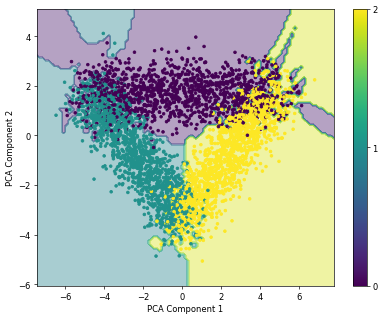

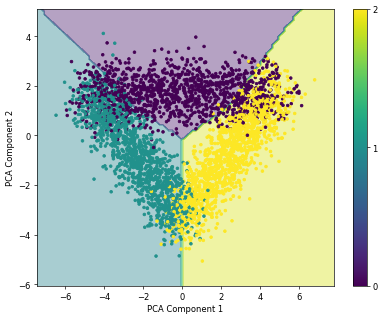

In [71]:
def pca_train(matrix, nb_dim) : 
    # Substract the mean of every feature 
    mean_vector = np.mean(matrix, axis=0)
    centered_data = matrix - mean_vector

    # Calculate the covariance matrix
    N = matrix.shape[0]  
    cov = (centered_data.T @ centered_data) / (N - 1)

    # Calculate the trace to calculate the variance explained
    trace = np.trace(cov)

    # Calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Select the number of eigenvectors you want (= nb_dim)
    top_eigenvalues = eigenvalues[:nb_dim]
    top_eigenvectors = eigenvectors[:, :nb_dim]
    
    # Calculate the new projection of each data point 
    new = centered_data @ top_eigenvectors

    # return the variance explained by the projection
    variance = np.sum(top_eigenvalues) / trace

    return new, mean_vector, top_eigenvectors, variance

def pca_transform(matrix, mean_vector, top_eigenvectors):
    # Center the test data using the training mean
    centered_data = matrix - mean_vector

    # Project the test data onto the top eigenvectors
    new = centered_data @ top_eigenvectors

    return new

def plot_pca(x,y):
    plt.figure(figsize=(8, 6), dpi=60)
    scatter = plt.scatter(x[:, 0], x[:, 1], c=y, cmap='viridis', marker='o', s=10)
    plt.colorbar(scatter, ticks=[0,1,2])
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

def plot_pca_boundaries(x, y, k, resolution=400):
    # Create a mesh grid over the feature space
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))

    # Predict for each point in the mesh grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    z = [knn(labels=y, k=k, new_input=grid_points[i], features_set=x) for i in range(len(grid_points))]
    
    # Reshape z to match the shape of xx and yy
    z = np.array(z).reshape(xx.shape)
    
    # Plot decision boundary
    plt.figure(figsize=(8, 6), dpi=60)
    plt.contourf(xx, yy, z, alpha=0.4, cmap='viridis')
    #plt.scatter(grid_points[:, 0], grid_points[:, 1], c=z, cmap='viridis', alpha=0.4)
    
    # Scatter plot of the actual data
    scatter = plt.scatter(x[:, 0], x[:, 1], c=y, cmap='viridis', marker='o', s=10)
    plt.colorbar(scatter, ticks=[0,1,2])
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

x_pca, _,_,_ = pca_train(x_train, 2)

plot_pca_boundaries(x_pca, y_train, 1, resolution=100)

plot_pca_boundaries(x_pca, y_train, 1000, resolution=100)


/home/baptiste/MASTER1_S1/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/baptiste/MASTER1_S1/.venv/lib/python3.12/site-packages/matplotlib/collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


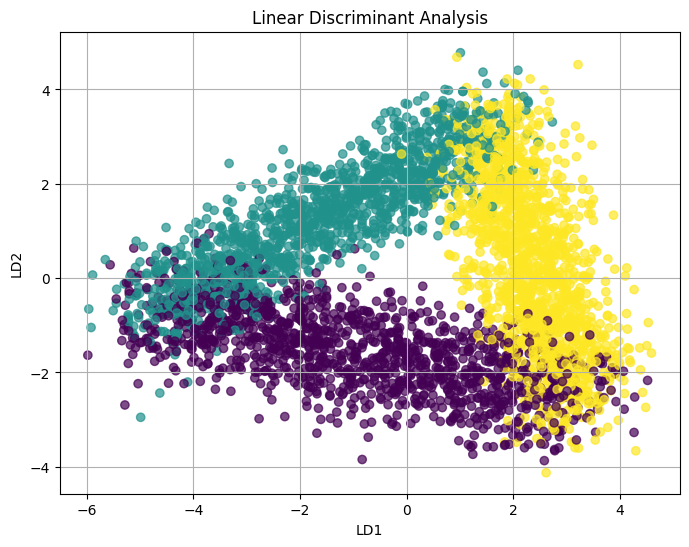

In [111]:
def compute_between_class_scatter(X, y, mean_vectors):
    n_features = X.shape[1]
    overall_mean = np.mean(X, axis=0).reshape(n_features, 1)
    S_B = np.zeros((n_features, n_features))
    classes = np.unique(y)
    for cls, mean_vec in zip(classes, mean_vectors):
        n_cls = X[y == cls].shape[0]
        mean_vec = mean_vec.reshape(n_features, 1)
        S_B += n_cls * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    return S_B

def lda_transform(features, labels, nb_dim):
    # Compute the d-dimensional mean vectors for the c classes
    classes = np.unique(labels)
    mean_vectors = []
    labels = labels.ravel()
    for c in classes:
        mean_vectors.append(np.mean(features[labels == c], axis=0))
    mean_vectors = np.array(mean_vectors)
    
    # Compute the within-class scatter matrix
    n_features = features.shape[1]
    within_matrix = np.zeros((n_features, n_features))
    between_matrix = np.zeros((n_features, n_features))
    overall_mean = np.mean(features, axis=0).reshape(n_features, 1)
    classes = np.unique(labels)

    for c, mean_vec in zip(classes, mean_vectors):
        # Compute within-class scatter
        class_samples = features[labels.ravel() == c]  # Flatten labels if needed
        class_scatter = np.sum([(row.reshape(n_features, 1) - mean_vec.reshape(n_features, 1))
                                @ (row.reshape(n_features, 1) - mean_vec.reshape(n_features, 1)).T
                                for row in class_samples], axis=0)
        within_matrix += class_scatter

        # Compute between-class scatter
        n_cls = class_samples.shape[0]
        mean_vec = mean_vec.reshape(n_features, 1)
        between_matrix += n_cls * (mean_vec - overall_mean) @ (mean_vec - overall_mean).T

    
    # Compute the eigenvectors and the eigenvalues
    eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_matrix).dot(between_matrix))
    
    # Select the nb_dim top eigenvectors
    sorted_indices = np.argsort(abs(eigen_values))[::-1]
    top_eigen_vectors = eigen_vectors[:, sorted_indices[:nb_dim]]
    
    # Step 6: Transform the data
    X_lda = features.dot(top_eigen_vectors)
    
    return X_lda, top_eigen_vectors

# Apply LDA
num_components = 2
X_lda, lda_components = lda_transform(x_train, y_train, num_components)

# Plot the results
plt.figure(figsize=(8, 6))
labels = np.unique(y_train)

plt.scatter(X_lda[:, 0], X_lda[:, 1], alpha=0.7, c=y_train, cmap='viridis')

plt.title('Linear Discriminant Analysis')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.grid(True)
plt.show()


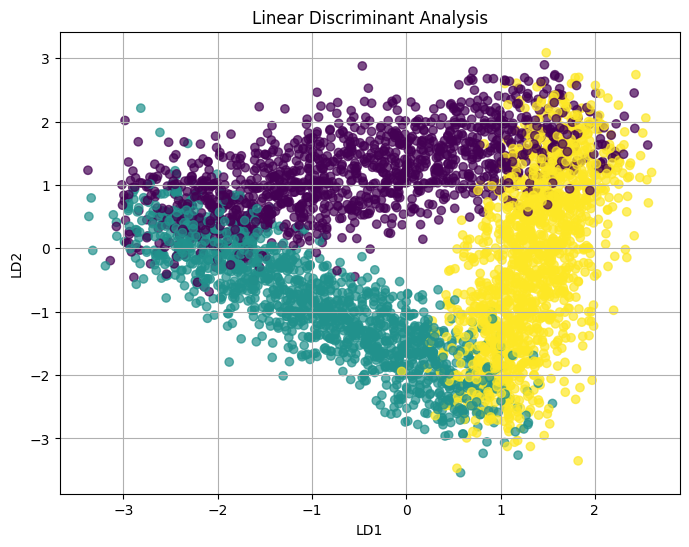

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Instantiate the LDA model
lda = LinearDiscriminantAnalysis(n_components=2)  # Project onto 2D space

# Fit the LDA model to the dataset and transform the features
X_lda = lda.fit_transform(x_train, y_train.ravel())

# Plot the results
plt.figure(figsize=(8, 6))
labels = np.unique(y_train)

plt.scatter(X_lda[:, 0], X_lda[:, 1], alpha=0.7, c=y_train, cmap='viridis')

plt.title('Linear Discriminant Analysis')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.grid(True)
plt.show()


### Metrics calculation : accuracy, confusion matrix, etc...

In [8]:
def metrics_calculation(cm):
    total_pred = np.sum(cm)
    TP = [] #True Positives for each class
    TN = [] #True Negatives for each class
    FP = [] #False Positives for each class
    FN = [] #False Negatives for each class
    for i in range(cm.shape[0]) : 
        TP.append(cm[i,i])
        FP.append(np.sum(cm[:, i]) - cm[i, i])
        FN.append(np.sum(cm[i, :]) - cm[i, i])
        TN.append(total_pred - (FP[i] + FN[i] + TP[i]))
    
    accuracy = np.sum(TP) / total_pred
    error = 1 - accuracy
    precision = np.sum(TP) / np.sum(TP+FP)
    recall = np.sum(TP) / np.sum(TP+FN)
    beta = 1
    f_measure = ((1+(beta**2)) * precision * recall) / (((beta**2) * precision) + recall)

    return accuracy, error, f_measure


In [9]:
# Returns the accuracy, confusion matrix of the prediction of the test set amongst the train set
# distance_mat : precomputed distances between train set and test set

def prediction_metrics(y_set_train, y_set_test, k, distance_mat=None, x_set_train=None, x_set_test=None):
    len_y_set_test = len(y_set_test)
    classes = np.unique(y_set_test)
    nb_classes = len(classes)
    confusion_matrix = np.zeros((nb_classes, nb_classes))

    # Using the precomputed distance matrix if provided, else using the x_set_train and x_set_test and computing the distances in the knn function
    knn_function = lambda i : knn(y_set_train, k, distance_mat[i]) if distance_mat is not None else knn(y_set_train, k, new_input=x_set_test[i], features_set=x_set_train)

    # Predict the class for each point of the set test amongst the set train
    for i in range(len_y_set_test) :
        y_pred = knn_function(i)
        y_actual = y_set_test[i, 0]

        # Filling the confusion matrix
        index_pred = np.where(classes == y_pred)[0][0]
        index_actual = np.where(classes == y_actual)[0][0]
        confusion_matrix[index_actual, index_pred] += 1

    accuracy, error, f_measure = metrics_calculation(cm = confusion_matrix)
    return accuracy, error, f_measure, confusion_matrix


# Tuning k by cross-validation

### Creating the k folds

In [10]:
# Splitting the training set into x_subsets for cross-validation
def k_folds(x_training_set, y_training_set, nb_folds):
    if nb_folds > x_training_set.shape[0]:
        raise ValueError("Error : number of folds exceeding the number of samples in the dataset.")
    # Shuffling the sets to get random folds
    indices = np.arange(x_training_set.shape[0])
    np.random.shuffle(indices)
    x_shuffled = x_training_set[indices]
    y_shuffled = y_training_set[indices]
    
    # Split the shuffled data into folds
    x = np.array_split(x_shuffled, nb_folds)
    y = np.array_split(y_shuffled, nb_folds)

    assert len(x) == len(y), "Error creating the subsets for cross-validation"
    return x, y

nb_folds = 5
x_subsets, y_subsets = k_folds(x_train, y_train, nb_folds)


### Pre-computing the distances of the k folds between them

In [11]:
# Returns a list of distances matrix of each fold of x_folds against the remaining folds
def list_distance_matrix(nb_folds, x_folds):
    # Precompute the distances between each fold and the k-1 other folds to accelerate computation
    list_dist_mat = []
    for i in range(nb_folds) : 
        x_tmp_training = np.concatenate([x_folds[j] for j in range(nb_folds) if j != i], axis=0)
        x_val_fold = x_folds[i]
        dist_mat = distance_matrix(x_val_fold, x_tmp_training)
        list_dist_mat.append(dist_mat)
    return list_dist_mat

list_dist_mat = list_distance_matrix(nb_folds=nb_folds, x_folds=x_subsets)


### Cross-validation algorithm

In [12]:
# Returns the metrics for a given k using cross-validation
def cross_validation(k, y_train_folds, nb_folds, list_dist_mat):
    fold_accuracies = []
    fold_errors = []
    fold_f_measures = []
    fold_confusion_matrices = []

    # Computing the metrics for each fold taken once(as a validation fold) over the k-1 training folds
    for i in range(nb_folds):
        # Remove the validation set from the training set
        y_tmp_training = np.concatenate([y_train_folds[j] for j in range(nb_folds) if j != i], axis=0)

        # Take the remaining fold as the validation fold
        y_val_fold = y_train_folds[i]
        
        fold_accuracy, fold_error, fold_f_measure, fold_cm = (prediction_metrics(distance_mat=list_dist_mat[i],
                                                     y_set_train=y_tmp_training, 
                                                     y_set_test=y_val_fold, 
                                                     k=k))
        fold_accuracies.append(fold_accuracy)
        fold_errors.append(fold_error)
        fold_f_measures.append(fold_f_measure)
        fold_confusion_matrices.append(fold_cm)
    
    # Returning the mean of the metrics
    mean_accuracy = np.mean(fold_accuracies)
    mean_error = np.mean(fold_errors)
    mean_f_measure = np.mean(fold_f_measures)
    mean_confusion_matrix = np.mean(fold_confusion_matrices, axis=0)
    return mean_accuracy, mean_error, mean_f_measure, mean_confusion_matrix


### Finding the best k using cross-validation

In [13]:
# Returns the best k using cross-validation
def tuning_k(nb_folds, y_folds, k_range, list_dist_mat):
    list_accuracies = []
    list_errors = []
    list_f_measures = []
    list_confusion_matrices = []

    # Iterate over the whole k range
    for k in tqdm(k_range) : 
        # Get the mean metrics for this k over the entire folds using cross-validation
        mean_acc, mean_error, mean_f_measure, mean_cm = cross_validation(k, y_folds, nb_folds, list_dist_mat)
        list_accuracies.append(mean_acc)  
        list_errors.append(mean_error)
        list_f_measures.append(mean_f_measure)
        list_confusion_matrices.append(mean_cm)

    max_accuracy = max(list_accuracies)
    best_k = k_range[list_accuracies.index(max_accuracy)] 

    # Returning the best k found, the mean accuracies for each k over the folds, and the mean CM for each k
    return best_k, list_accuracies, list_errors, list_f_measures, list_confusion_matrices

k_max = int(x_train.shape[0] - (x_train.shape[0] / nb_folds))
k_range = range(1, 500)
best_k, accuracies, errors, f_measures, confusion_matrices = tuning_k(nb_folds=nb_folds, y_folds=y_subsets, k_range=k_range, list_dist_mat=list_dist_mat)
max_accuracy = max(accuracies)


100%|██████████| 499/499 [00:32<00:00, 15.34it/s]


### Plotting of the accuracies with respect to k

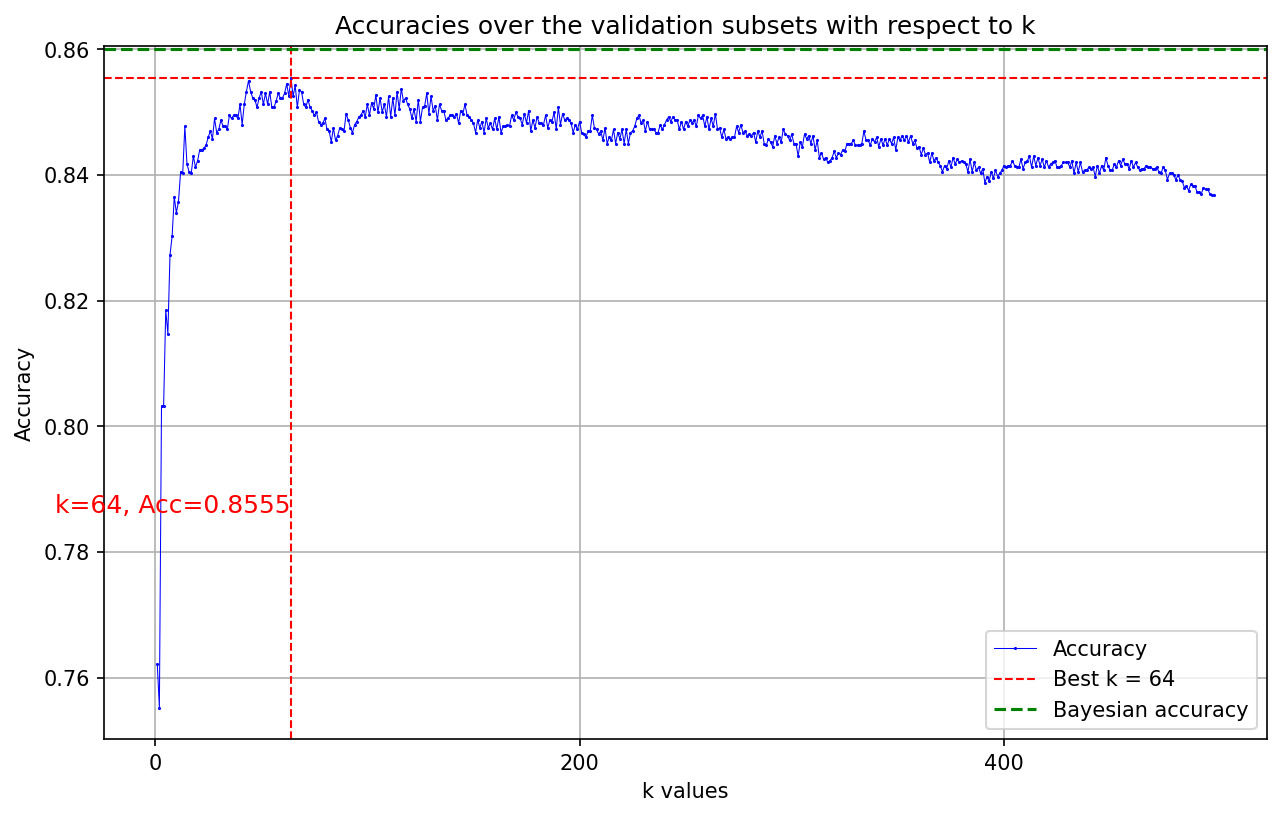

In [14]:
def plot_accuracies(tab_accuracies, y_accuracy, x_k, title):
    plt.figure(figsize=(10, 6), dpi=150) 
    plt.plot(k_range, tab_accuracies, label='Accuracy', marker='o', color='b',markersize=0.5,linestyle='-', linewidth=.5)
    plt.axvline(x=x_k, color='r', linestyle='--', linewidth=1, label=f'Best k = {best_k}')
    plt.axhline(y=y_accuracy, color='r', linestyle='--', linewidth=1)
    plt.axhline(y=.86, color='g', linestyle='--', label=f'Bayesian accuracy')
    plt.text(x_k, y_accuracy-0.07, f'k={x_k}, Acc={y_accuracy:.4f}', 
            horizontalalignment='right', verticalalignment='bottom', 
            color='red', fontsize=12)
    plt.xlabel('k values')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, max(k_range)+2, 200)) 
    #plt.axhline(y=(1/3), color='orange', linestyle='--', label=f'Random Guessing')
    plt.grid(True)
    plt.legend()
    plt.title(title)
    plt.show()

plot_accuracies(accuracies, max_accuracy, best_k, "Accuracies over the validation subsets with respect to k")


### Confusion matrix of the best k

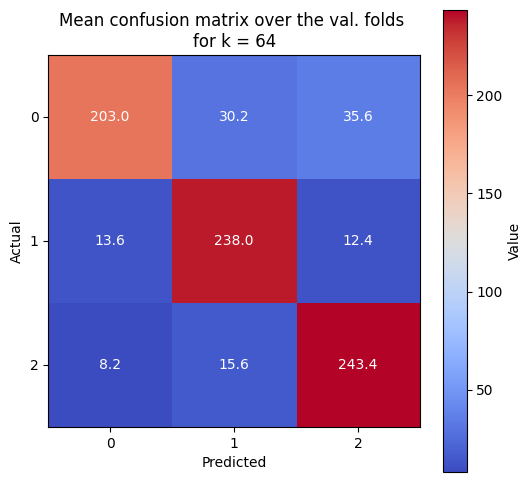

In [15]:
def plot_confusion_matrix(matrix, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(matrix, cmap='coolwarm')
    plt.colorbar(label='Value')
    for (i, j), value in np.ndenumerate(matrix):
        plt.text(j, i, f'{value}', ha='center', va='center', color='white')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.xticks(np.arange(matrix.shape[1]), ['0', '1', '2'])
    plt.yticks(np.arange(matrix.shape[0]), ['0', '1', '2'])
    plt.show()

confusion_mat_best_k = confusion_matrices[accuracies.index(max_accuracy)]
plot_confusion_matrix(confusion_mat_best_k,"Mean confusion matrix over the val. folds \nfor k = "+str(best_k))


### Prediction on the test set using the best k found
We now calculate the accuracy on the test set using the k found by cross-validation.\
Here, the accuracy can be over 0.86 as the test set drawn from the data is not exactly representative of the underlying distribution

Accuracy : 0.86


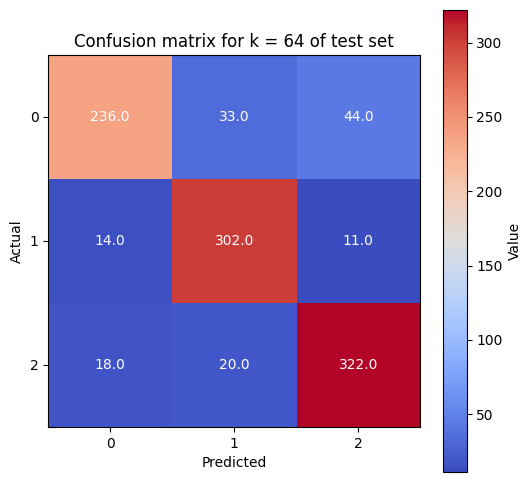

In [16]:
test_acc, test_error, test_f_measure, test_cm = prediction_metrics(y_set_train=y_train, y_set_test=y_test, k=best_k, x_set_train=x_train, x_set_test=x_test)
print("Accuracy : "+str(test_acc))
plot_confusion_matrix(test_cm,"Confusion matrix for k = "+str(best_k)+" of test set")

test_accuracies = []
test_errors = []
test_f_measures = []
dist_mat_test_train = distance_matrix(x_test, x_train)
for k in k_range : 
    k_acc, k_error, k_f_measure, k_cm = prediction_metrics(y_set_train=y_train, y_set_test=y_test, k=k, distance_mat=dist_mat_test_train)
    test_accuracies.append(k_acc)
    test_errors.append(k_error)
    test_f_measures.append(k_f_measure)


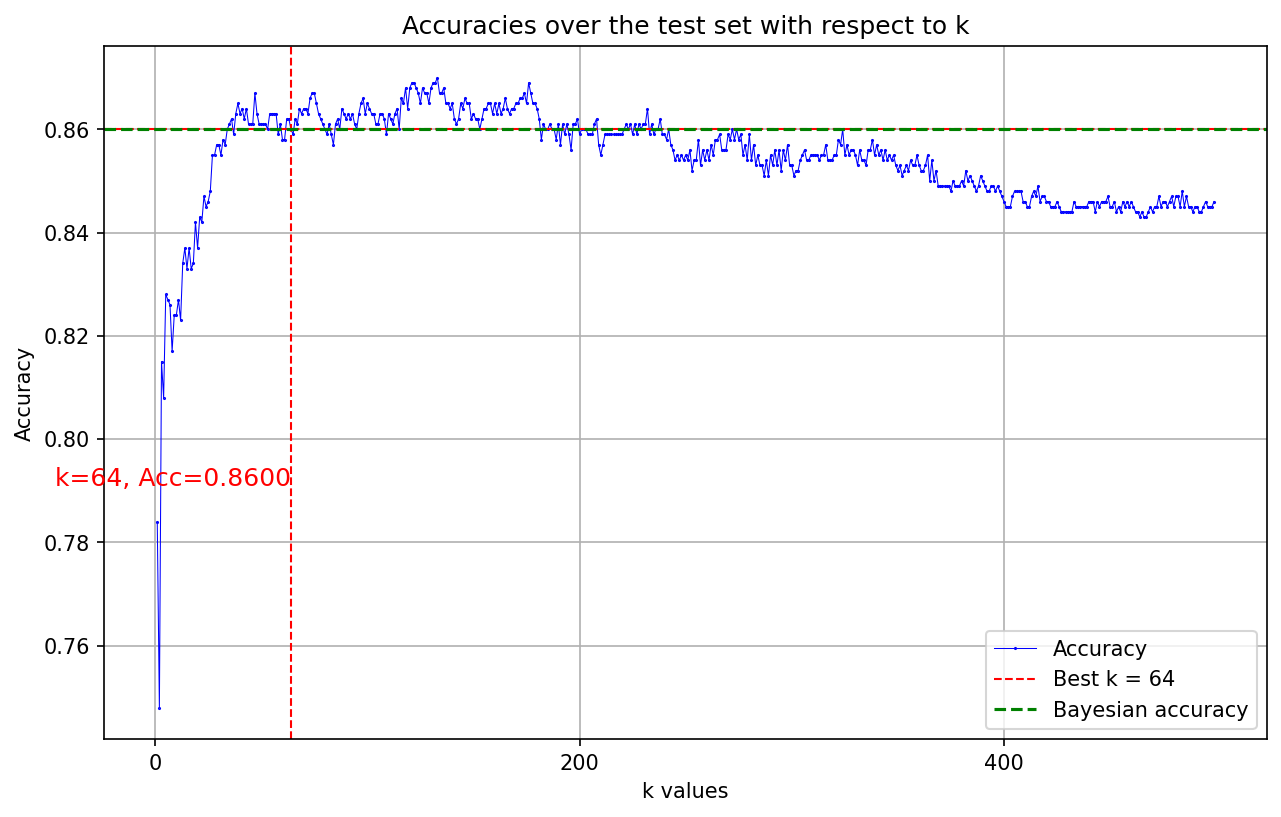

In [17]:
plot_accuracies(test_accuracies, test_acc, best_k,"Accuracies over the test set with respect to k")


# Reducing complexity

### Data Reduction : Step 1

Initial data :


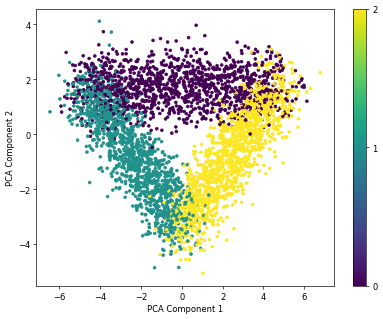

----------------
[6, 8, 11, 15, 19, 21, 23, 24, 31, 38, 43, 46, 50, 52, 53, 57, 58, 63, 65, 66, 75, 78, 85, 94, 95, 97, 102, 103, 109, 113, 117, 120, 129, 141, 145, 146, 148, 159, 161, 162, 168, 171, 172, 173, 177, 181, 186, 204, 205, 210, 219, 230, 242, 246, 247, 248, 255, 258, 260, 265, 269, 270, 271, 272, 279, 281, 284, 291, 295, 297, 298, 300, 301, 303, 313, 325, 326, 327, 330, 338, 343, 353, 355, 357, 359, 360, 364, 368, 370, 371, 378, 380, 382, 393, 396, 399, 401, 408, 415, 423, 428, 430, 433, 436, 439, 446, 453, 454, 455, 461, 463, 471, 476, 485, 487, 494, 504, 507, 511, 514, 519, 522, 524, 525, 540, 547, 552, 555, 557, 560, 561, 563, 565, 568, 575, 577, 582, 583, 584, 587, 595, 603, 610, 626, 638, 639, 640, 641, 642, 647, 648, 658, 660, 664, 665, 668, 669, 676, 678, 679, 685, 689, 704, 708, 719, 722, 726, 727, 738, 742, 745, 747, 752, 753, 756, 767, 775, 777, 785, 790, 794, 797, 800, 801, 804, 805, 814, 815, 816, 818, 826, 828, 834, 838, 839, 845, 847, 848, 849, 850, 852, 854, 

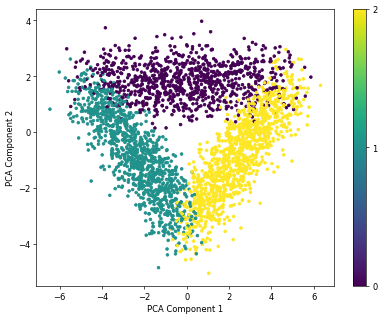

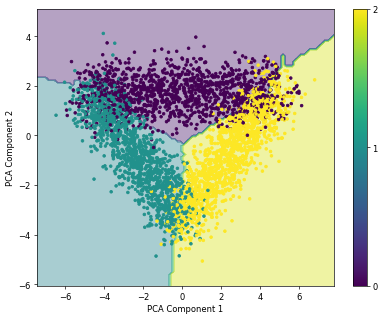

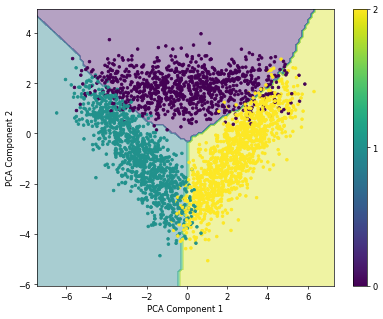

In [78]:
def remove_outliers_and_bayes_region(x_set, y_set) :
    n_k = 1
    # Splittiing randomly S into S1 and S2
    x_cleaned, y_cleaned = k_folds(x_training_set=x_set, y_training_set=y_set, nb_folds=2)

    list_indices_S1 = []
    list_indices_S2 = []

    while(True):
        # Classifying S1 with S2 using the 1-NN rule
        for i in range (len(x_cleaned[0])):
            y_pred = knn(labels = y_cleaned[1], k=n_k, new_input = x_cleaned[0][i], features_set = x_cleaned[1])
            y_actual = y_cleaned[0][i]
            # Stocking the examples misclassified
            if (y_pred != y_actual):
                list_indices_S1.append(i)

        if len(list_indices_S1) > 0:
            x_cleaned[0] = np.delete(x_cleaned[0], list_indices_S1, axis=0)
            y_cleaned[0] = np.delete(y_cleaned[0], list_indices_S1, axis=0)

        # Classifying S2 with the new set S1 using the 1-NN rule
        for i in range(len(x_cleaned[1])):
            y_pred = knn(labels = y_cleaned[0], k=n_k, new_input = x_cleaned[1][i], features_set = x_cleaned[0])
            y_actual = y_cleaned[1][i]
            # Stocking the examples misclassified
            if (y_pred != y_actual):
                list_indices_S2.append(i)

        if len(list_indices_S2) > 0:
            x_cleaned[1] = np.delete(x_cleaned[1], list_indices_S2, axis=0)
            y_cleaned[1] = np.delete(y_cleaned[1], list_indices_S2, axis=0)

        print("----------------")
        print(list_indices_S1)
        print(list_indices_S2)

        # If there is nothing in list_indices of S1 and S2 it means that all examples have been correctly classified 
        if (len(list_indices_S1) == 0 and len(list_indices_S2) == 0):
            break

        list_indices_S1.clear()
        list_indices_S2.clear()

    new_x_cleaned = np.concatenate((x_cleaned[0], x_cleaned[1]))
    new_y_cleaned = np.concatenate((y_cleaned[0], y_cleaned[1]))
    return new_x_cleaned, new_y_cleaned

print("Initial data :")
x_train_pca, mean_vector, top_eigenvectors, _ = pca_train(x_train, 2)
plot_pca(x=x_train_pca, y=y_train)

x_train_cleaned, y_train_cleaned = remove_outliers_and_bayes_region(x_set=x_train, y_set=y_train)

print("Cleaned data, outliers and examples of the bayesian region removed :")
print(x_train_cleaned.shape)
x_train_cleaned_pca = pca_transform(x_train_cleaned, mean_vector, top_eigenvectors)
plot_pca(x=x_train_cleaned_pca, y=y_train_cleaned)

plot_pca_boundaries(x_train_pca, y_train, k = best_k, resolution=100)
plot_pca_boundaries(x_train_cleaned_pca, y_train_cleaned, k = best_k, resolution=100)


### Prediction on the test set over the cleaned data

In [19]:
test_accuracies_cleaned = []
test_errors_cleaned = []
test_f_measures_cleaned = []
dist_mat_test_cleaned_train = distance_matrix(x_test, x_train_cleaned)
for k in k_range : 
    k_acc, k_error, k_f_measure, k_cm = prediction_metrics(y_set_train=y_train_cleaned, y_set_test=y_test, k=k,distance_mat=dist_mat_test_cleaned_train)
    test_accuracies_cleaned.append(k_acc)
    test_errors_cleaned.append(k_error)
    test_f_measures_cleaned.append(k_f_measure)


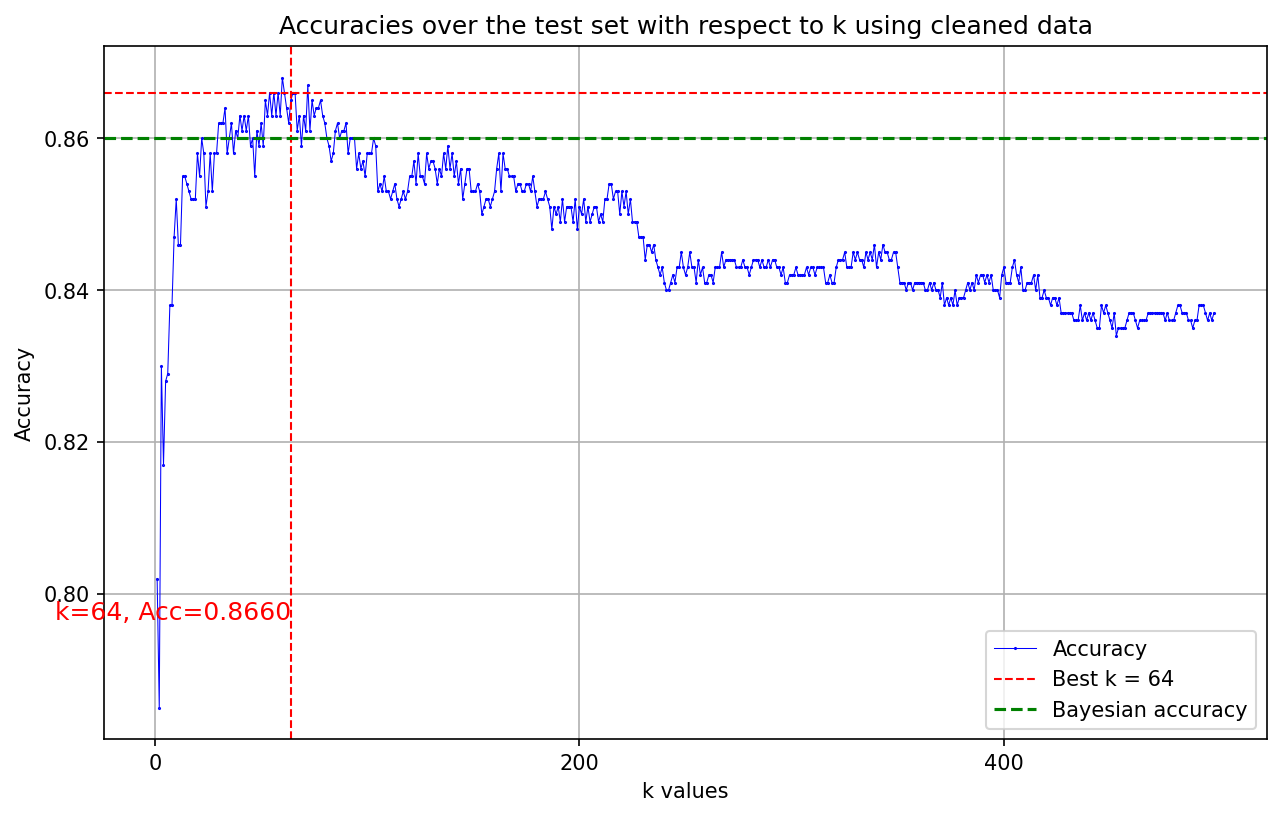

In [20]:
plot_accuracies(test_accuracies_cleaned, test_accuracies_cleaned[best_k], best_k,"Accuracies over the test set with respect to k using cleaned data")


### Data reduction : Step 2
### Condensed nearest neighbor rule

Data shape after CNN :
(794, 21)
Decision boundaries of cleaned data, before CNN:


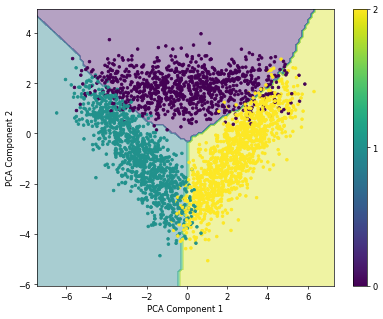

Decision boundaries after CNN :


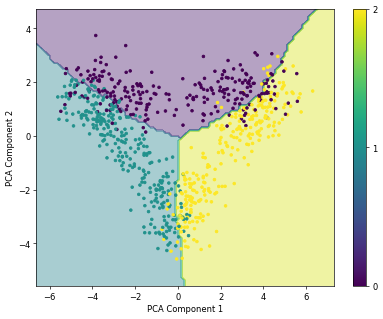

In [83]:
def condensed_nearest_neighbor(x_set, y_set):
    storage_x = np.empty((0, x_set.shape[1]))
    storage_y = np.array([])
    len_storage_prec = 0
    len_storage_actual = 0

    # Drawing randomly the first sample and putting it in Storage
    ith_example = np.random.randint(1, x_set.shape[0])
    storage_x = np.vstack([storage_x, x_set[ith_example]])
    storage_y = np.append(storage_y, y_set[ith_example])

    # While no stabilization of Storage 
    while(True):
        for i in range(len(x_set)):
            if any((storage_x == x_set[i]).all(axis=1)): # If the example is already in storage skip it
                continue

            y_pred = knn(labels=storage_y, k=1, new_input=x_set[i], features_set=storage_x)
            y_actual = y_set[i]

            # If xi is incorrectly classified we add it to the storage, else we ignore it
            if (y_pred != y_actual) :
                storage_x = np.vstack([storage_x, x_set[i]])
                storage_y = np.append(storage_y, y_set[i])
            
        len_storage_actual = len(storage_x)

        if (len_storage_prec == len_storage_actual):
            break

        len_storage_prec = len_storage_actual

    return storage_x, storage_y

x_CNN, y_CNN = condensed_nearest_neighbor(x_train_cleaned, y_train_cleaned)
print("Data shape after CNN :")
print(x_CNN.shape)

x_CNN_pca = pca_transform(x_CNN, mean_vector, top_eigenvectors)

print("Decision boundaries of cleaned data, before CNN:")
plot_pca_boundaries(x_train_cleaned_pca, y_train_cleaned, k=best_k,resolution=100)
print("Decision boundaries after CNN :")
plot_pca_boundaries(x_CNN_pca, y_CNN, k=best_k, resolution=100)


### Prediction on the test set over the condensed data

In [22]:
test_accuracies_CNN = []
test_errors_CNN = []
test_f_measures_CNN = []
dist_mat_test_CNN = distance_matrix(x_test, x_CNN)
for k in k_range : 
    k_acc, k_error, k_f_measure, k_cm = prediction_metrics(y_set_train=y_CNN, y_set_test=y_test, k=k, distance_mat=dist_mat_test_CNN)
    test_accuracies_CNN.append(k_acc)
    test_errors_CNN.append(k_error)
    test_f_measures_CNN.append(k_f_measure)


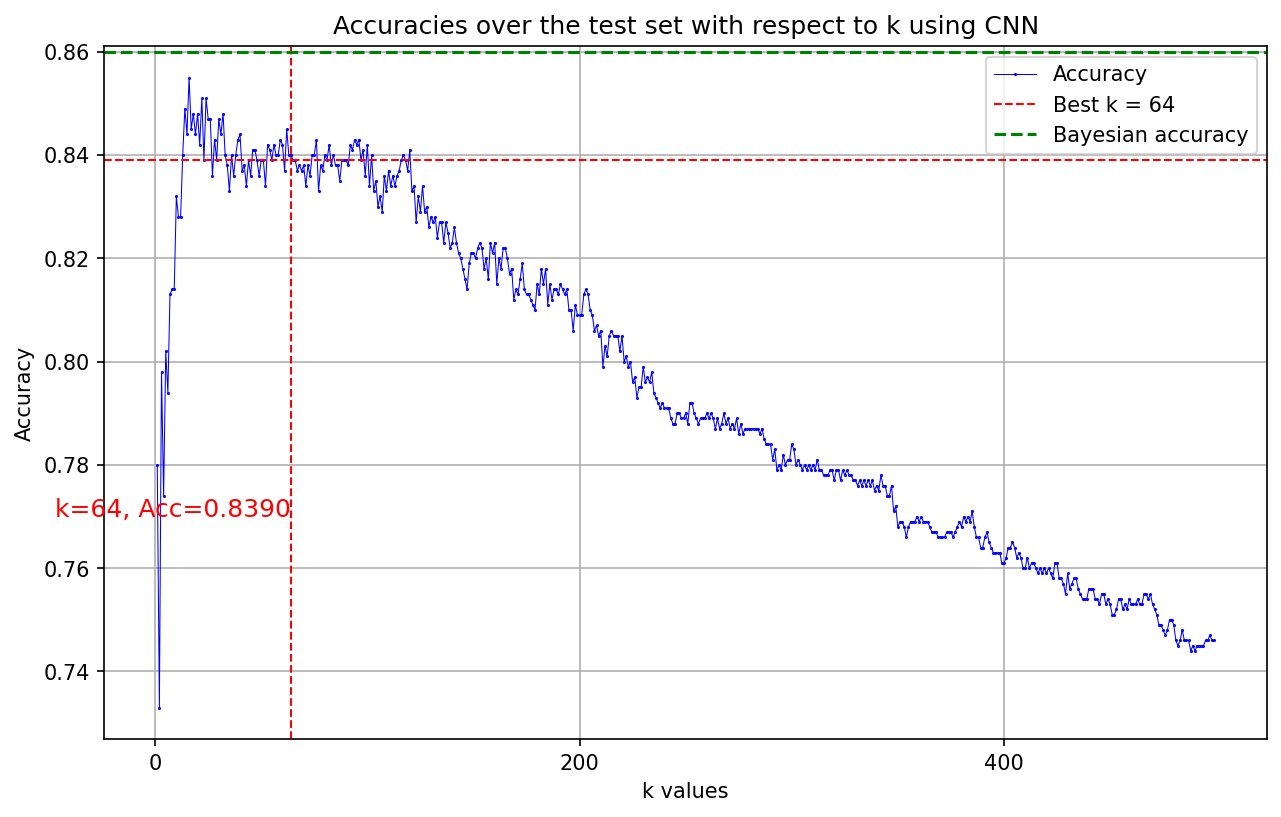

In [23]:
plot_accuracies(test_accuracies_CNN, test_accuracies_CNN[best_k], best_k,"Accuracies over the test set with respect to k using CNN")


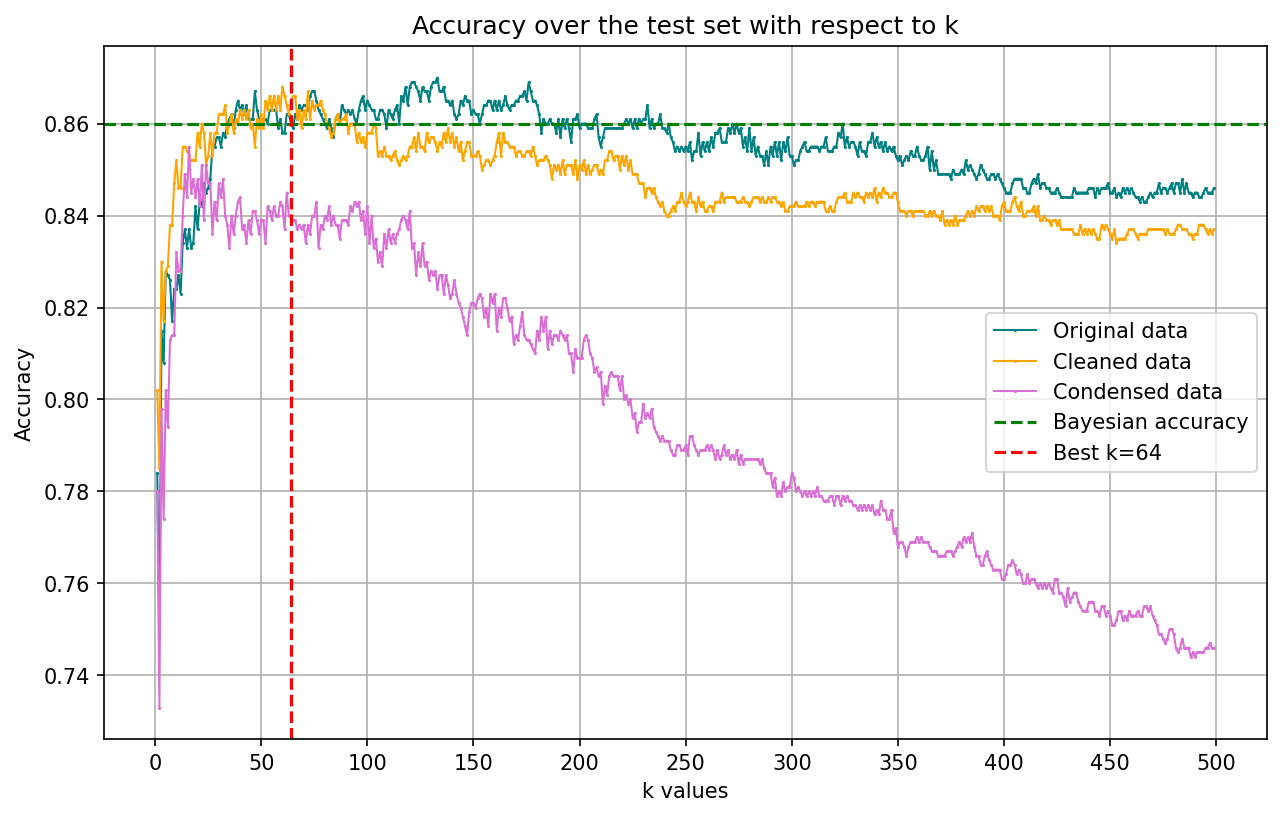

In [24]:
plt.figure(figsize=(10, 6), dpi=150) 
mksize = 0.5
plt.plot(k_range, test_accuracies, label='Original data', marker='o', color='teal',markersize=mksize,linestyle='-', linewidth=1)
plt.plot(k_range, test_accuracies_cleaned, label='Cleaned data', marker='o', color='orange', markersize=mksize, linestyle='-', linewidth=1)
plt.plot(k_range, test_accuracies_CNN, label='Condensed data', marker='o', color='orchid', markersize=mksize, linestyle='-', linewidth=1)
plt.axhline(y=.86, color='g', linestyle='--', label=f'Bayesian accuracy')
plt.axvline(x=best_k, color='r', linestyle='--', label='Best k='+str(best_k))
plt.xlabel('k values')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, max(k_range)+2, 50))
#plt.yticks(np.arange(30, 90, 10)) 
#plt.axhline(y=(1/3), color='orange', linestyle='--', label=f'Random Guessing')
plt.grid(True)
plt.legend()
plt.title("Accuracy over the test set with respect to k")
plt.show()


### Speed comparison between the different data complexity

In [25]:
speed_results = []
sizes = range(10,x_test.shape[0],10) # Dataset sizes

for size in tqdm(sizes) : 
    indices = np.random.choice(x_test.shape[0], size=size, replace=False) # Select a random subset of x_train of size = 'size'
    x_test_subset = x_test[indices]
    y_test_subset = y_test[indices]

    start_time = time.perf_counter() 
    _, _, _, _ = prediction_metrics(y_set_train=y_train, y_set_test=y_test_subset, k=1, x_set_train=x_train, x_set_test=x_test_subset)
    end_time = time.perf_counter()
    elapsed_time_normal = end_time - start_time

    start_time = time.perf_counter() 
    _,_,_,_ = prediction_metrics(y_set_train=y_train_cleaned, y_set_test=y_test_subset, k=1, x_set_train=x_train_cleaned, x_set_test=x_test_subset)
    end_time = time.perf_counter()
    elapsed_time_cleaned = end_time - start_time

    start_time = time.perf_counter() 
    _,_,_,_ = prediction_metrics(y_set_train=y_CNN, y_set_test=y_test_subset, k=1, x_set_train=x_CNN, x_set_test=x_test_subset)
    end_time = time.perf_counter()
    elapsed_time_CNN = end_time - start_time

    speed_results.append((size, elapsed_time_normal, elapsed_time_cleaned, elapsed_time_CNN))

sizes, time_normal, time_cleaned, time_CNN  = zip(*speed_results)


100%|██████████| 99/99 [00:20<00:00,  4.78it/s]


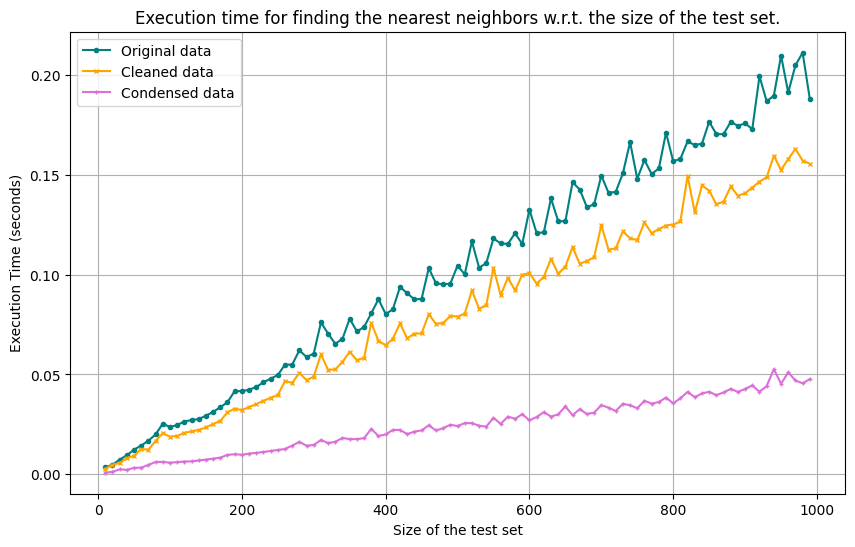

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, time_normal, marker='o', label="Original data", color='teal', markersize = 3)
plt.plot(sizes, time_cleaned, marker='x', label="Cleaned data", color='orange',markersize = 3)
plt.plot(sizes, time_CNN, marker='+', label="Condensed data", color='orchid',markersize = 3)
plt.xlabel("Size of the test set")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution time for finding the nearest neighbors w.r.t. the size of the test set.")
plt.legend()
plt.grid(True)
plt.show()


# Speeding-up the calculation

In [27]:
def nearest_neighbor(x, x_array):
    current_NN = -1
    distance_NN_new_query = 0
    distance_NN = np.inf 
    for i in range(x_array.shape[0]):
        distance_NN_new_query = euclidian_distance(x, x_array[i])
        if (distance_NN_new_query < distance_NN): # If the new query is closer we update the nearest neighbor
            distance_NN = distance_NN_new_query
            current_NN = i

    return current_NN

def speed_nearest_neighbor(x, x_array, precomputed_matrix): # Only for k = 1 (for now)
    current_NN = -1
    distance_NN_new_query = 0
    distance_NN = np.inf 
    candidates = np.array(range(x_array.shape[0]))  # Start with all candidates

    while len(candidates) > 0:
        i = candidates[0]  # Pick the first candidate
        distance_NN_new_query = euclidian_distance(x, x_array[i])
        if distance_NN_new_query < distance_NN: # If the new query is closer, update the nearest neighbor
            distance_NN = distance_NN_new_query
            current_NN = i

        # Prune candidates if they are in the sphere centered at Xi of radius d(X,Xi)-dmin OR out of the sphere centered at Xi of radius d(X,Xi)+dmin
        radius_inside = distance_NN_new_query - distance_NN
        radius_outside = distance_NN_new_query + distance_NN

        distances_to_i = precomputed_matrix[i][candidates]  # Distances from the new query to current candidates
        candidates = candidates[(distances_to_i >= radius_inside) & (distances_to_i <= radius_outside)]  # Keep only valid candidates

        candidates = candidates[candidates != i] # Remove the current candidate

    return current_NN

sizes = range(200,4001,200) # Dataset sizes
n = 1000  # Number of test queries

results = []

correct_pred_normal = 0
correct_pred_speed = 0

for size in tqdm(sizes): # Compare speed for each dataset size
    correct_pred_normal = 0
    correct_pred_speed = 0
    #print(f"\nEvaluating with dataset size: {size}")

    indices = np.random.choice(x_train.shape[0], size=size, replace=False) # Select a random subset of x_train of size = 'size'
    x_train_subset = x_train[indices]
    y_train_subset = y_train[indices]

    precomputed_dist_matrix_train = distance_matrix(x_train_subset, x_train_subset) # Precompute the distance matrix for speed_nearest_neighbor

    start_time = time.perf_counter() # Measure execution time for speed_nearest_neighbor

    for i in range(n):
        speed_nn = speed_nearest_neighbor(x_test[i], x_train_subset, precomputed_dist_matrix_train)

    end_time = time.perf_counter()
    elapsed_time_speed = end_time - start_time
    #print(f"Execution time for speed nearest neighbor: {elapsed_time_speed:.10f} seconds")

    start_time = time.perf_counter() # Measure execution time for normal nearest_neighbor

    for i in range(n):
        normal_nn = nearest_neighbor(x_test[i], x_train_subset)

    end_time = time.perf_counter()
    elapsed_time_normal = end_time - start_time
    #print(f"Execution time for normal nearest neighbor: {elapsed_time_normal:.10f} seconds")

    results.append((size, elapsed_time_speed, elapsed_time_normal))

sizes, times_speed, times_normal = zip(*results) 


100%|██████████| 20/20 [04:47<00:00, 14.39s/it]


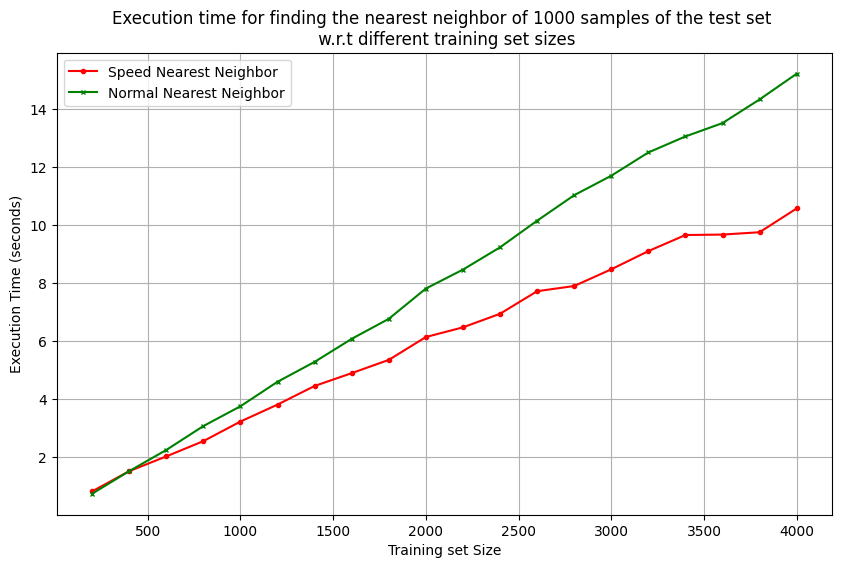

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, times_speed, marker='o', label="Speed Nearest Neighbor", color='r', markersize = 3)
plt.plot(sizes, times_normal, marker='x', label="Normal Nearest Neighbor", color='g',markersize = 3)
plt.xlabel("Training set Size")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution time for finding the nearest neighbor of "+str(n)+" samples of the test set \n w.r.t different training set sizes")
plt.legend()
plt.grid(True)
plt.show()


# Curse of dimensionnality
We show here that KNN is affected by the curse of dimensionnality.\
We calculate the mean accuracy over the test set using all the k from k_range for dimensions of PCA from 1 to 21

In [35]:
k_range_pca = k_range[100:300]
nb_k = len(k_range_pca)
individual_variances = []
previous_var = 0 # To save the variance for each value of p
pca_accuracies = []
for p in tqdm(range(1,22)):
    x_train_pca, mean_vector, top_eigenvectors, variance = pca_train(x_train, p) # Training pca on p dimensions and projection de training set 
    x_test_pca = pca_transform(x_test, mean_vector, top_eigenvectors) # Projecting the test set intot the p dimensions

    mean_acc = 0
    distance_mat = distance_matrix(x_test_pca, x_train_pca)
    for k in k_range_pca:
        p_acc, p_error, p_f_measure, p_cm = prediction_metrics(y_set_train=y_train, y_set_test=y_test, k=k, distance_mat=distance_mat)
        mean_acc += p_acc
    
    mean_acc = mean_acc/nb_k
    pca_accuracies.append(mean_acc)
    individual_variances.append(variance-previous_var)
    previous_var = variance

    """ p_acc, p_error, p_f_measure, p_cm = prediction_metrics(y_set_train=y_train, y_set_test=y_test, k=k, x_set_train=x_train_pca, x_set_test=x_test_pca)
    pca_accuracies.append(p_acc) """


100%|██████████| 21/21 [01:14<00:00,  3.53s/it]



We clearly see here that the mean accuracy decreases with the increase of the number of dimensions.

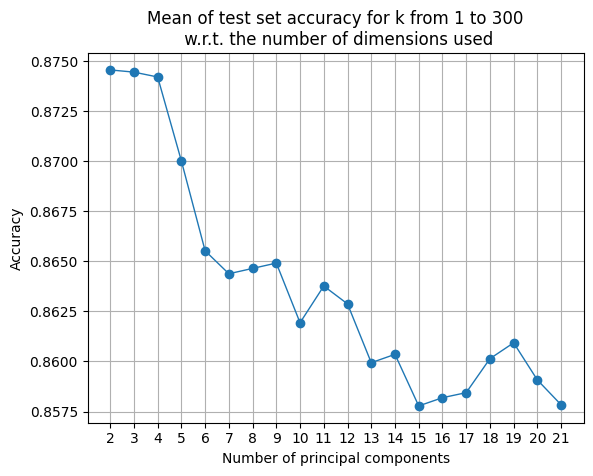

In [34]:
p_values = range(1, 22)  # p values from 2 to 21
plt.plot(p_values[1:], pca_accuracies[1:], marker='o', linewidth=1)
plt.title("Mean of test set accuracy for k from 1 to "+str(max(k_range_pca))+"\n w.r.t. the number of dimensions used")
plt.xlabel("Number of principal components")
plt.ylabel("Accuracy")
plt.xticks(np.arange(2, 22, 1)) 
plt.grid(True)
plt.show()

# add the accuracy with the LDA


Explained variance is also important when performing a PCA. Here is a plot of the explained variance w.r.t. the number of dimensions
(In a supervised setting, the explained variance isn't much important.)

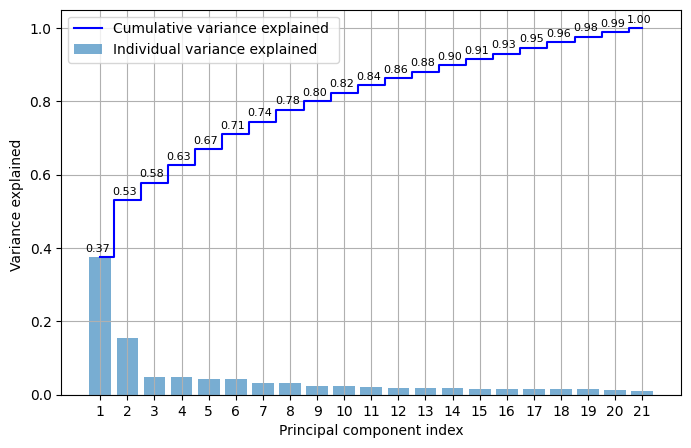

In [ ]:
cumulative_variances = np.cumsum(individual_variances)
plt.figure(figsize=(8, 5))
plt.bar(p_values, individual_variances, alpha=0.6, label="Individual variance explained ")
plt.step(p_values, cumulative_variances, where='mid', color='blue', label="Cumulative variance explained ")
plt.xticks(ticks=p_values, labels=[str(i) for i in p_values])
plt.xlabel("Principal component index")
plt.ylabel("Variance explained ")
plt.legend(loc="upper left")
for x, y in zip(p_values, cumulative_variances):
    plt.text(x-0.1, y+0.01, f"{y:.2f}", ha='center', va='bottom', fontsize=8)
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()


# TEST

In [ ]:
""" import numpy as np
from sklearn.model_selection import PredefinedSplit, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
scikit_x_train = x_train.copy()
scikit_y_train = y_train.copy()
scikit_x_test = x_test.copy()
scikit_y_test = y_test.copy()
scikit_k_range = k_range
scikit_x_subsets = x_subsets.copy()
scikit_y_subsets = y_subsets.copy() """


' import numpy as np\nfrom sklearn.model_selection import PredefinedSplit, cross_val_score\nfrom sklearn.neighbors import KNeighborsClassifier\nscikit_x_train = x_train.copy()\nscikit_y_train = y_train.copy()\nscikit_x_test = x_test.copy()\nscikit_y_test = y_test.copy()\nscikit_k_range = k_range\nscikit_x_subsets = x_subsets.copy()\nscikit_y_subsets = y_subsets.copy() '

In [ ]:
""" # Combine all folds into one array
scikit_x_combined = np.concatenate(scikit_x_subsets, axis=0)
scikit_y_combined = np.concatenate(scikit_y_subsets, axis=0)

# Create an array of indices where each index corresponds to the fold number
scikit_fold_indices = []
for i, scikit_subset in enumerate(scikit_x_subsets):
    scikit_fold_indices.extend([i] * len(scikit_subset))
scikit_fold_indices = np.array(scikit_fold_indices)

# Define PredefinedSplit with your fold indices
scikit_ps = PredefinedSplit(scikit_fold_indices)

scikit_mean_accuracies = []

# Perform cross-validation for each k using your predefined folds
for scikit_k in scikit_k_range:
    scikit_knn = KNeighborsClassifier(n_neighbors=scikit_k)
    scikit_scores = cross_val_score(scikit_knn, scikit_x_combined, scikit_y_combined.ravel(), cv=scikit_ps, scoring='accuracy')
    scikit_mean_accuracies.append(scikit_scores.mean())  # Average accuracy for this k """


" # Combine all folds into one array\nscikit_x_combined = np.concatenate(scikit_x_subsets, axis=0)\nscikit_y_combined = np.concatenate(scikit_y_subsets, axis=0)\n\n# Create an array of indices where each index corresponds to the fold number\nscikit_fold_indices = []\nfor i, scikit_subset in enumerate(scikit_x_subsets):\n    scikit_fold_indices.extend([i] * len(scikit_subset))\nscikit_fold_indices = np.array(scikit_fold_indices)\n\n# Define PredefinedSplit with your fold indices\nscikit_ps = PredefinedSplit(scikit_fold_indices)\n\nscikit_mean_accuracies = []\n\n# Perform cross-validation for each k using your predefined folds\nfor scikit_k in scikit_k_range:\n    scikit_knn = KNeighborsClassifier(n_neighbors=scikit_k)\n    scikit_scores = cross_val_score(scikit_knn, scikit_x_combined, scikit_y_combined.ravel(), cv=scikit_ps, scoring='accuracy')\n    scikit_mean_accuracies.append(scikit_scores.mean())  # Average accuracy for this k "

In [ ]:
""" scikit_best_k = scikit_k_range[np.argmax(scikit_mean_accuracies)]
print(f'Best k: {scikit_best_k}, Mean Accuracy: {max(scikit_mean_accuracies):.4f}')

scikit_knn_best = KNeighborsClassifier(n_neighbors=scikit_best_k)
scikit_knn_best.fit(scikit_x_train, scikit_y_train.ravel())  # Fit on the entire training set
scikit_test_acc = scikit_knn_best.score(scikit_x_test, scikit_y_test)  # Evaluate on the test set
print(f'Test Set Accuracy with Best k: {scikit_test_acc:.4f}')

### Plotting Accuracies
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(scikit_k_range, scikit_mean_accuracies, label='Accuracy', marker='o', color='b', markersize=1, linestyle='-', linewidth=.5)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Accuracy')
plt.title('KNN Classifier Accuracy for Different k Values')
plt.xticks(np.arange(0, max(scikit_k_range) + 1, 100))
scikit_max_accuracy = max(scikit_mean_accuracies)
scikit_best_k = scikit_k_range[np.argmax(scikit_mean_accuracies)]
plt.axvline(x=scikit_best_k, color='r', linestyle='--', linewidth=1, label=f'Best k = {scikit_best_k}')
plt.axhline(y=scikit_max_accuracy, color='r', linestyle='--', linewidth=1)
plt.axhline(y=.86, color='g', linestyle='--', label=f'Bayesian accuracy')
plt.text(scikit_best_k - 1, scikit_max_accuracy-.01, f'k={scikit_best_k}, Acc={scikit_max_accuracy:.4f}', 
         horizontalalignment='right', verticalalignment='bottom', 
         color='red', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()
 """


" scikit_best_k = scikit_k_range[np.argmax(scikit_mean_accuracies)]\nprint(f'Best k: {scikit_best_k}, Mean Accuracy: {max(scikit_mean_accuracies):.4f}')\n\nscikit_knn_best = KNeighborsClassifier(n_neighbors=scikit_best_k)\nscikit_knn_best.fit(scikit_x_train, scikit_y_train.ravel())  # Fit on the entire training set\nscikit_test_acc = scikit_knn_best.score(scikit_x_test, scikit_y_test)  # Evaluate on the test set\nprint(f'Test Set Accuracy with Best k: {scikit_test_acc:.4f}')\n\n### Plotting Accuracies\nplt.figure(figsize=(10, 6), dpi=150)\nplt.plot(scikit_k_range, scikit_mean_accuracies, label='Accuracy', marker='o', color='b', markersize=1, linestyle='-', linewidth=.5)\nplt.xlabel('Number of Neighbors (k)')\nplt.ylabel('Mean Accuracy')\nplt.title('KNN Classifier Accuracy for Different k Values')\nplt.xticks(np.arange(0, max(scikit_k_range) + 1, 100))\nscikit_max_accuracy = max(scikit_mean_accuracies)\nscikit_best_k = scikit_k_range[np.argmax(scikit_mean_accuracies)]\nplt.axvline(x=sci

In [ ]:
""" # Calculate test set accuracy over the whole k range
scikit_test_accuracies = []
for k in scikit_k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(scikit_x_train, scikit_y_train.ravel())  # Fit on the entire training set
    test_acc = knn.score(scikit_x_test, scikit_y_test)  # Evaluate on the test set
    scikit_test_accuracies.append(test_acc)
 """


' # Calculate test set accuracy over the whole k range\nscikit_test_accuracies = []\nfor k in scikit_k_range:\n    knn = KNeighborsClassifier(n_neighbors=k)\n    knn.fit(scikit_x_train, scikit_y_train.ravel())  # Fit on the entire training set\n    test_acc = knn.score(scikit_x_test, scikit_y_test)  # Evaluate on the test set\n    scikit_test_accuracies.append(test_acc)\n '

In [ ]:
""" 
# Plotting Accuracies for both training mean accuracy and test accuracy
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(scikit_k_range, scikit_mean_accuracies, label='Training Mean Accuracy', marker='o', markersize=1, linestyle='-', linewidth=0.5)
plt.plot(scikit_k_range, scikit_test_accuracies, label='Test Set Accuracy', marker='s', markersize=1, linestyle='-', linewidth=0.5, color='orange')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Classifier Accuracy for Different k Values')
plt.xticks(np.arange(0, max(scikit_k_range) + 1, 100))

# Highlight best k for training set accuracy
scikit_max_accuracy = max(scikit_mean_accuracies)
scikit_best_k = scikit_k_range[np.argmax(scikit_mean_accuracies)]
plt.axvline(x=scikit_best_k, color='r', linestyle='--', linewidth=1, label=f'Best k = {scikit_best_k}')
plt.axhline(y=scikit_max_accuracy, color='r', linestyle='--', linewidth=1, label=f'Max Training Acc = {scikit_max_accuracy:.4f}')
plt.axhline(y=.86, color='g', linestyle='--', label='Bayesian Accuracy')

# Add annotations for best training accuracy
plt.text(scikit_best_k - 1, scikit_max_accuracy - 0.01, f'k={scikit_best_k}, Acc={scikit_max_accuracy:.4f}', 
         horizontalalignment='right', verticalalignment='bottom', color='red', fontsize=12)

plt.grid(True)
plt.legend()
plt.show()
 """


" \n# Plotting Accuracies for both training mean accuracy and test accuracy\nplt.figure(figsize=(10, 6), dpi=150)\nplt.plot(scikit_k_range, scikit_mean_accuracies, label='Training Mean Accuracy', marker='o', markersize=1, linestyle='-', linewidth=0.5)\nplt.plot(scikit_k_range, scikit_test_accuracies, label='Test Set Accuracy', marker='s', markersize=1, linestyle='-', linewidth=0.5, color='orange')\nplt.xlabel('Number of Neighbors (k)')\nplt.ylabel('Accuracy')\nplt.title('KNN Classifier Accuracy for Different k Values')\nplt.xticks(np.arange(0, max(scikit_k_range) + 1, 100))\n\n# Highlight best k for training set accuracy\nscikit_max_accuracy = max(scikit_mean_accuracies)\nscikit_best_k = scikit_k_range[np.argmax(scikit_mean_accuracies)]\nplt.axvline(x=scikit_best_k, color='r', linestyle='--', linewidth=1, label=f'Best k = {scikit_best_k}')\nplt.axhline(y=scikit_max_accuracy, color='r', linestyle='--', linewidth=1, label=f'Max Training Acc = {scikit_max_accuracy:.4f}')\nplt.axhline(y=.8